In [2]:
# these packages can be installed from https://github.com/hengenlab

import neuraltoolkit as ntk
import musclebeachtools as mbt
import numpy as np
import os
import criticality as cr

from datetime import date
today = date.today()
today = today.strftime("%Y_%m_%d")

In [33]:
pwd

'/media/HlabShare/Yifan_Work/Document/spk_data/XYF12/block1'

In [14]:
neurons = np.load('/media/HlabShare/Yifan_Work/Document/spk_data/XYF12/block1/XYF12_b1_neurons_quality.npy',allow_pickle = True)

goodCells = [neuron for neuron in neurons if neuron.quality in [1,2]]

for i in np.arange(0,len(goodCells)):
    goodCells[i].remove_large_amplitude_spikes(3.5,lstd_deviation=True, start=False, end=False, lplot=False)

goodCells = [neuron for neuron in goodCells if neuron.cell_type == 'RSU']

# regular neural avalanches analysis

In [27]:
# load 4 hours of data
start = 0
end = 4
ava_binsz = 0.04     # bin size of avalanches

# transform spiketimes to spikewords
data= mbt.n_spiketimes_to_spikewords(goodCells,ava_binsz,3600*start,3600*end,1)


Data has 34 neurons with length 360000*binsize
perc_threshold  3
Time took in get_avalanches is 0.2779691219329834 seconds


In [ ]:
condition = 'Q12RSU_25%'
pltname = today
saveloc = os.getcwd() 

burstM = 15
tM = 10
perc = 0.3
r = cr.get_avalanches(data, perc)
burst = r['S']
T = r['T']

params = {'flag': 1, 'bm': burstM, 'tm': tM, 'pltname': pltname,'saveloc': saveloc,'plot': True}
Result_all = cr.AV_analysis(r['S'], r['T'], params, nfactor_bm=6, nfactor_tm=3,nfactor_bm_tail=0.8, nfactor_tm_tail=0.85)

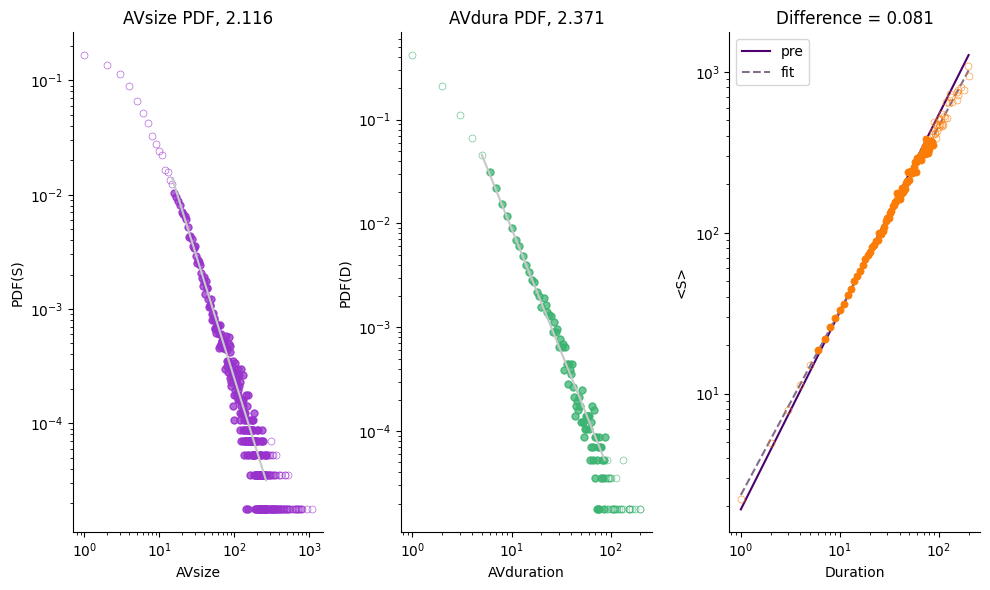

In [31]:
Result_all['scaling_relation_plot']

In [ ]:
# p_value test

burstM = 35
tM = 12

params_pvalue = {'flag': 2, 'bm': burstM, 'tm': tM, 'pltname': "pvalue",
          'saveloc': saveloc,'plot': True}

Result2 = cr.AV_analysis(burst, T, params_pvalue, nfactor_bm=6, nfactor_tm=4,nfactor_bm_tail=0.8, nfactor_tm_tail=0.8)

In [23]:
# result of the p-value test
print(Result2['P_burst'])
print(Result2['P_t'])

0.848
0.614


# Neural avalanches analysis with behavior

In [34]:
block = 1

os.chdir('/media/HlabShare/Yifan_Work/Document/spk_data/XYF12/block' + str(block))

neurons = np.load('/media/HlabShare/Yifan_Work/Document/spk_data/XYF12/block1/XYF12_b1_neurons_quality.npy',allow_pickle = True)

goodCells = [neuron for neuron in neurons if neuron.quality in [1,2]]

for i in np.arange(0,len(goodCells)):
    goodCells[i].remove_large_amplitude_spikes(3.5,lstd_deviation=True, start=False, end=False, lplot=False)

goodCells = [neuron for neuron in goodCells if neuron.cell_type == 'RSU']

behavior = np.load('XYF12_SW_block' + str(block) +'.npy')

In [35]:

start = 0
end = 12
ava_binsz = 0.04     # bin size of avalanches

# transform spiketimes to spikewords
data= mbt.n_spiketimes_to_spikewords(goodCells,ava_binsz,3600*start,3600*end,1)

In [37]:

saveloc = os.getcwd()    

length = 3600*4               # 4h per block
n_bins = length/ava_binsz     # number of bins in each block to be analyzed 
edges = np.arange(0, np.shape(data)[1], n_bins)   # separate data into several blocks

# pre-process of the behavior data
sleep_states = behavior[:,np.where(behavior[0] <= 43200)[0]]
idx = np.where(behavior[0] <= 43200)[0][-1]
ss = sleep_states[1]
ss[np.where(ss>5)[0]] = 5.0   # correct the error for quiet wake 
ts = sleep_states[0]
ts = np.insert(ts, 0, 0)
if int(ts[-1]) != 43200:
    ts = np.append(ts,43200)
    ss = np.append(ss, behavior[1,idx + 1])
ts = ts/ava_binsz

# get mask with sleep states
mask = np.zeros((int(ts[-1]),))
print(mask.shape)

for i in np.arange(0,ss.shape[0],1):
    mask[int(ts[i]):int(ts[i+1]),] = ss[i]   

# get indicies for analysis
indicies_sleep = np.where(np.logical_or(mask == 2, mask == 3))[0]
indicies_wake = np.where(np.logical_or(mask == 1, mask == 5))[0]


(1080000,)


In [38]:
edges

array([     0., 360000., 720000.])

In [56]:
burstM = 25
tM = 12
perc = 0.25

time_bin = [int(edges[0]), int(edges[0]+n_bins)]   # here just analyze the first 4h; use loop for the whole block
indicies_sleep_current = indicies_sleep[np.logical_and(indicies_sleep >= time_bin[0], indicies_sleep <= time_bin[1] -1)]  
indicies_wake_current = indicies_wake[np.logical_and(indicies_wake >= time_bin[0], indicies_wake <= time_bin[1] -1)]

sleepdata = data[:,indicies_sleep_current]
r1 = cr.get_avalanches(sleepdata, perc = perc)
pltname = 'XYF12_sleep'
params = {'flag': 1, 'bm': burstM, 'tm': tM, 'pltname': pltname,'saveloc': saveloc,'plot': True}
Result_sleep = cr.AV_analysis(r1['S'], r1['T'], params, nfactor_bm=10, nfactor_tm=6, nfactor_bm_tail=0.7, nfactor_tm_tail=0.85)


wakedata = data[:,indicies_wake_current]
r1 = cr.get_avalanches(wakedata, perc = perc)
pltname = 'XYF12_wake'
params = {'flag': 1, 'bm': burstM, 'tm': tM, 'pltname': pltname,'saveloc': saveloc,'plot': True}
Result_wake = cr.AV_analysis(r1['S'], r1['T'], params, nfactor_bm=6, nfactor_tm=3,nfactor_bm_tail=0.8, nfactor_tm_tail=0.85)


Data has 34 neurons with length 154300*binsize
perc_threshold  1
Time took in get_avalanches is 0.10974454879760742 seconds
burst  [ 1 44  9 ...  5 30  2]
burst[burst > xmin]  [44  9 31 ...  5 30  2]
0  19639
1  140.13921649559768
2  0.007135761316543495
dKS Final  0.00015964405102625312
alpha  2.6000877380371126
burst min:  24
burst max: 288
burst  [ 1 12  2 ...  3 11  1]
burst[burst > xmin]  [12  2  8 ...  5  3 11]
0  16488
1  128.40560735419618
2  0.007787821891933296
dKS Final  0.00026972742704656216
beta  2.872990417480473
time min: 7
time max: 193
fit_sigma  [1.14550652 0.84966023]
sigma  1.170554822061283
Data has 34 neurons with length 205700*binsize
perc_threshold  3
Time took in get_avalanches is 0.1532917022705078 seconds
burst  [ 1  3  4 ... 22  9 19]
burst[burst > xmin]  [ 3  4  9 ... 22  9 19]
0  26521
1  162.85269417482783
2  0.006140518614487682
dKS Final  0.9886085452061815
alpha  1.9747947692871115
burst min:  21
burst max: 267
burst  [1 2 2 ... 4 3 4]
burst[burst > x

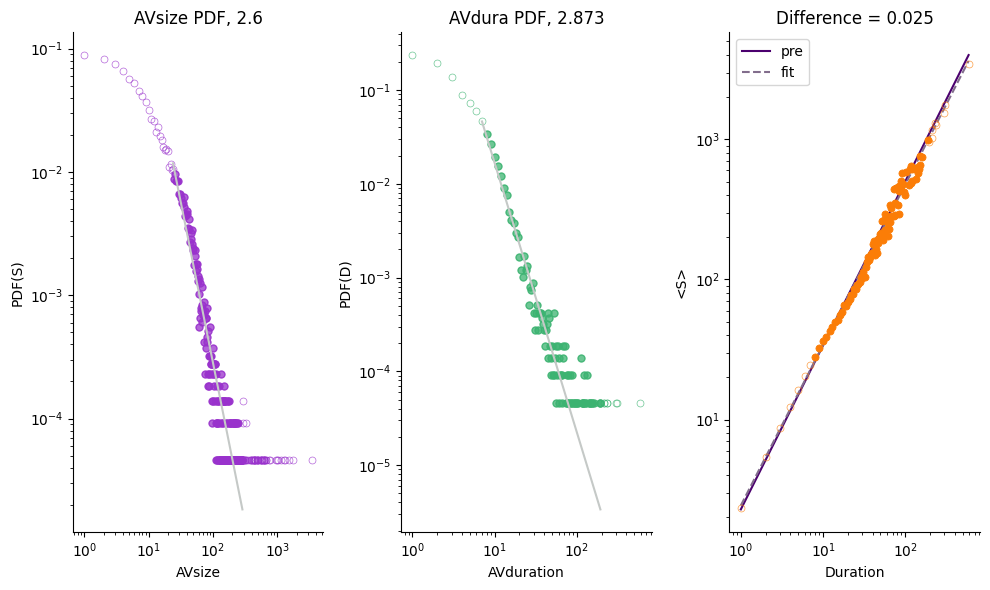

In [58]:
Result_sleep['scaling_relation_plot']

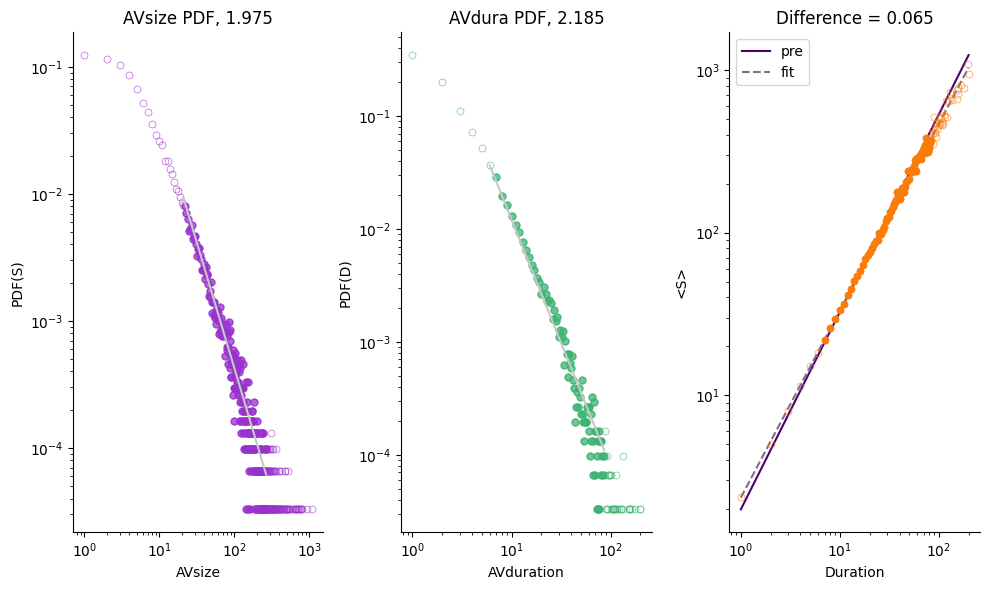

In [43]:
Result_wake['scaling_relation_plot']